In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader


from sklearn.model_selection import train_test_split

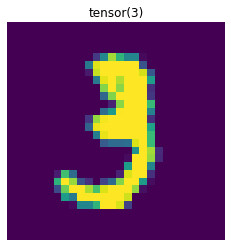

In [2]:
from tensorflow.keras.datasets import mnist


(features_train, targets_train), (features_test, targets_test) = mnist.load_data()

# Convert to float32.

features_train, features_test = np.array(features_train, np.float32), np.array(features_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28).
num_features=784

features_train, features_test = features_train.reshape([-1, num_features]), features_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1].

features_train, features_test = features_train / 255., features_test / 255

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. 
#Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(featuresTrain[10].reshape(28,28))
plt.axis("off")
plt.title(str(targetsTrain[10]))
plt.savefig('graph.png')
plt.show()



In [3]:
# Create ANN Model
class ANNModel(nn.Module):
    
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ANNModel, self).__init__()
    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [4]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.757047712802887  Accuracy: 83.0 %
Iteration: 1000  Loss: 0.5120163559913635  Accuracy: 88.75 %
Iteration: 1500  Loss: 0.5777590274810791  Accuracy: 89.86000061035156 %
Iteration: 2000  Loss: 0.2974214255809784  Accuracy: 90.9000015258789 %
Iteration: 2500  Loss: 0.20514923334121704  Accuracy: 91.61000061035156 %
Iteration: 3000  Loss: 0.32946473360061646  Accuracy: 92.05000305175781 %
Iteration: 3500  Loss: 0.26435840129852295  Accuracy: 92.7699966430664 %
Iteration: 4000  Loss: 0.29361921548843384  Accuracy: 93.12000274658203 %
Iteration: 4500  Loss: 0.41867321729660034  Accuracy: 93.37000274658203 %


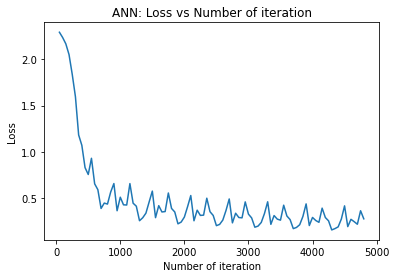

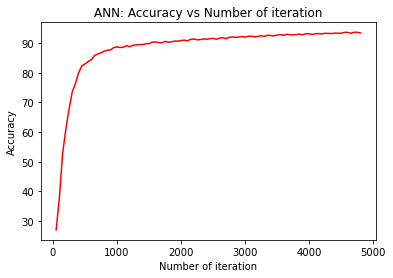

In [5]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [6]:
# Create CNN Model
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    ######################################################################       
    #### DESIGN LAYERS :
    ### SEQUENCE: CONV1,ACTIVATION1,POOLING1,  CONV2,ACTIVATION2,POOLING2, LINEAR(FC)
    self.layer1 = nn.Conv2d(1, 2, 5)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.layer2 = nn.Conv2d(2, 4, 5)
    self.pool2 = nn.MaxPool2d(4)
    self.layer3 = nn.Linear(4 * 2 * 2, 10)

  def forward(self, x):
    # COMBINE LAYERS
    ## 1) CONV1
    out = self.layer1(x)

    ## 2) ACTIVATION1
    out = self.relu(out)

    ## 3) POOLING1
    out = self.pool1(out)
    
    ## 4) CONV2
    out = self.layer2(out)

    ## 5) ACTIVATION2
    out = self.relu(out)

    ## 6) POOLING2
    out = self.pool2(out)

    ## 7) flatten ########## DURING LAB WE JUST FORGOT FOLLOWING FLATTEN LAYER ###############
    out = out.view(out.size(0), -1)

    ## 8) LINEAR(FC)
    return self.layer3(out)


# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [7]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.24701125919818878  Accuracy: 89.95999908447266 %
Iteration: 1000  Loss: 0.24841807782649994  Accuracy: 92.4000015258789 %
Iteration: 1500  Loss: 0.3023819625377655  Accuracy: 92.79000091552734 %
Iteration: 2000  Loss: 0.21067528426647186  Accuracy: 93.4000015258789 %


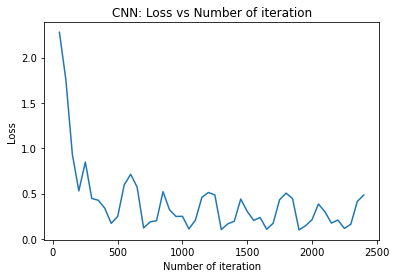

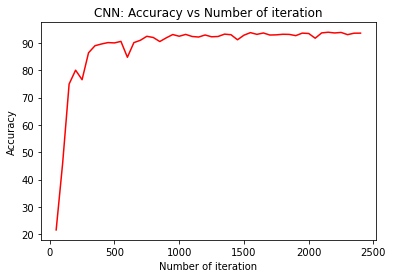

In [8]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

Try CNN on "Fruit" dataset. Also modify number of layers and observe the performance difference: 

https://www.kaggle.com/moltean/fruits


Or (In a case if you don't have that much dataPack available, download 20 images of apple and 20 images of orange from the internet and work on it with RANDOM state=Rollnumber stratergy, 80-20% training-testing division)





